In [1]:
import sympy 
sympy.init_printing()

Here we define variables and set up equations.

In [2]:
# symbols used
Ib = sympy.symbols('I_b', nonnegative=True)
Ic = sympy.symbols('I_c', nonnegative=True)                       # peak 
Vb = sympy.symbols('V_b')
Vc = sympy.symbols('V_c')                       # peak, phase to neutral
Rm = sympy.symbols('R_m', positive=True)                       # single phase motor resistance
k = sympy.symbols('k', positive=True)                          # phase to neutral
omega = sympy.symbols('omega', positive = True)
Rb = sympy.symbols('R_b', positive=True)
Voc = sympy.symbols('V_oc', positive=True)
Imm = sympy.symbols('I_mm')
Ibm = sympy.symbols('I_bm')
torque = sympy.symbols('tau')

# governing equations
battery_loop = sympy.Eq(Voc, Ib * Rb + Vb)
power_eq = sympy.Eq(Vb * Ib, Vc * Ic)
controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega)
regime_1 = sympy.Eq(Ic, Imm)
regime_2 = sympy.Eq(Ib, Ibm)
regime_3 = sympy.Eq(Vb, Vc)

is_three_phase = False

if is_three_phase == True:
    power_eq = sympy.Eq(Vb * Ib, sympy.Rational(3/2) * Vc * Ic)
    controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega / sympy.sqrt(3))
    regime_3 = sympy.Eq(Vb, sympy.sqrt(3) * Vc)


# numbers for numerical evaluation
ev_system = {Rb: 0.120, Voc:50, Imm: 150, Ibm:100, Rm: 0.128, k:1.0}

We model the section where the controller is at max motor current by using the regime 1 equation and solving.

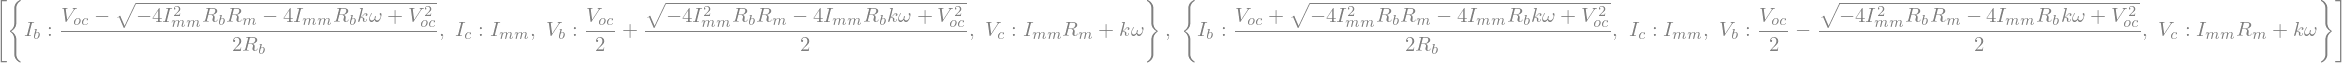

In [3]:
constant_torque = sympy.solve([power_eq, battery_loop, controller_loop, regime_1], exclude=[Rb, Rm, k, Imm, Voc])
constant_torque 

We expect the battery current to increase as omega increases (positive derivative) so we select the first equation.
We see that this derivative is positive but will be imaginary for some combinations of variables.

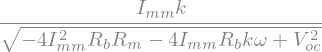

In [4]:
sympy.diff(constant_torque[0][Ib], omega)

# Conditions of Validity for Battery Current Equation in Constant Torque Region

There is a motor speed at which the battery current has no real solution.
This should reflect when the battery power exceeds its limit set by the open circuit voltage and the internal resistance.

Q: can I show that the battery current at the speed is one-half the short circuit current?

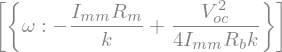

In [5]:
radical = constant_torque[0][Ib].args[2].args[1].args[1].args[0]
sympy.solve(radical, 0, omega)

This numerical value of 13.24 roughly agrees with my expectations.

In [6]:
ev_system = {Voc:50, Imm: 200, Ibm:300, Rb: 0.120, Rm: 0.064, k:1.0}
sympy.solve(radical, 0, omega)[0][omega].evalf(subs=ev_system)

By substituting the speed at which the radical goes imaginary, we find this occurs when the battery current is at half of the short circuit current, as we expect.

Q: does this change in the 3-phase case?

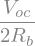

In [7]:
omega_max_power = sympy.solve(radical, 0, omega)[0][omega]
constant_torque[0][Ib].subs(omega, omega_max_power).simplify()

If the maximum motor current is high enough, the battery will not be able to satisfy it.
I expect that the value in the radical for the battery current equation will go below zero in this case.

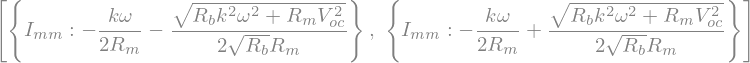

In [8]:
radical = constant_torque[0][Ib].args[2].args[1].args[1].args[0]
sympy.solve(radical, 0, Imm)

In [9]:
sympy.solve(radical, 0, Imm)[1][Imm].subs(omega, 0).evalf(subs=ev_system)

We are interested in what battery current is necessary for the controller current at zero rpm.
A maximum battery current below this will constrain the operation of the system. 



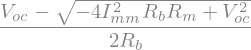

In [10]:
constant_torque[0][Ib].subs(omega, 0)

We also note that the maximum current possible is when the square root equals zero.
This looks like the short circuit dissipated power in the battery equals four times the motor resistive dissipation at max controller current.

In [11]:
constant_torque[0][Ib].subs(omega, 0).args[2].args[1].args[1].args[0]

TODO: unify this result and explanation with those for the equation above

In [12]:
sympy.solve(constant_torque[0][Ib].subs(omega, 0).args[2].args[1].args[1].args[0], 0, Imm)[1][Imm].evalf(subs=ev_system)

We can express this current in terms of the battery's short circuit current, $I_{sc} = V_{oc}/R_b$ and the power being dissipated in the resistor at maximum current, $P_{rm} = I_{mm}^2 R_m$.

For an ideal voltage source ($R_b = 0$), this should equal the motor resistor dissipation power divided by the battery voltage. 

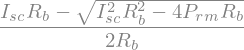

In [13]:
omeganl = sympy.Symbol('omega_nl')
Isc = sympy.Symbol('I_sc', positive=True)
Prm = sympy.Symbol('P_rm', positive=True)
# collect, expand, simplify, together
constant_torque[0][Ib].subs(omega, 0).subs(Voc, Isc*Rb).subs(Imm**2*Rm, Prm)

In the constant power region, the battery current and voltage are constant and we can solve for the controller current and voltage.

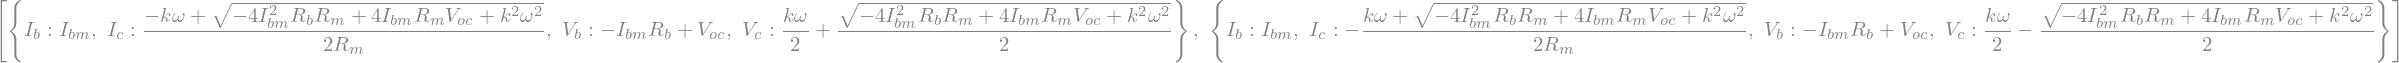

In [14]:
constant_power = sympy.solve([power_eq, battery_loop, controller_loop, regime_2], exclude=[Rb, Rm, k, Ibm, Voc])
constant_power
#sympy.diff(battery_limit[0][Ic], omega) 

We select the equation that has a positive motor current.

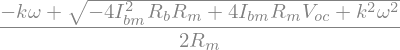

In [15]:
constant_power[0][Ic]

TODO: under what conditions will this controller current equation fail?

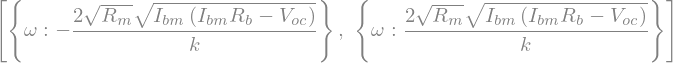

In [16]:
# this is the Ibm at which the radical goes negative
sympy.solve(constant_power[0][Ic].args[2].args[0].args[0], 0, omega)

In [17]:
sympy.solve(constant_power[0][Ic].args[2].args[0].args[0], 0, omega)[1][omega].evalf(subs=ev_system)

At some point, the motor is spinning fast enough that the battery current will fall below maximum.
Above this RPM, the duty cycle will be at max so the controller voltage will equal the battery voltage.
Solving we get the following equations.

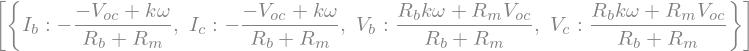

In [18]:
duty_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_3], exclude=[Rb, Rm, k, Voc])
duty_limit

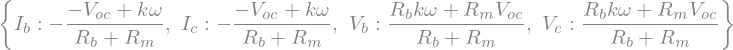

In [19]:
duty_limit[0]

The no load speed occurs when the battery or controller current reaches zero at the expected frequency of the open-circuit voltage divided by the voltage constant.

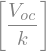

In [20]:
# no load speed is when Ib and Ic = 0, Vb = Voc, and Vc = Voc/sqrt(3)
no_load_speed = sympy.solve(sympy.Eq(duty_limit[0][Ib], 0), omega)
no_load_speed

- TODO: at what omega do we switch from max controller current to max battery current?
- TODO: at what omega do we switch from max battery current to 100% duty cycle?
- TODO: what intuitive model explains the 100% duty cycle thing?
- TODO: what is the maximum controller current I can reach? How does it depend on my other parameters?

We can find the frequency at which the battery current reaches maximum by setting the battery current in the phase-current-limited regime to the battery current maximum. 

*The expression resembles a speed for a controller voltage calculated from the voltage drops at the maximum currents. 
Note, the scaling factors might be equivalent to the duty cycles.*

TODO: think about how the input voltage will appear on the other side of the controller according to the ratio of the currents.

Takeaway: to raise crossover frequency, raise max battery current and lower battery internal resistance.
However, the battery resistance must be low enough to offset the squaring of the battery current.

TODO: is there an optimum battery current? figure this out by differentiating this equation with respect to battery current and setting to zero.

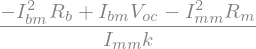

In [21]:
sympy.solve(sympy.Eq(constant_torque[0][Ib], Ibm), omega)[0]

It looks like setting the battery maximum current to half of the short circuit current will extend the frequency as much as possible.

TODO: what happens physically and mathematically if the battery current goes above half of the short circuit current? 
We'll be past the maximum power transfer point, I think.

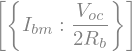

In [22]:
sympy.solve(sympy.diff(sympy.solve(sympy.Eq(constant_torque[0][Ib], Ibm), omega)[0], Ibm), 0, Ibm)

We can find the frequency at which the constant power regime ends by setting the controller currents equal in the constant power region and the BEMF region.

TODO: won't we get the same result from setting the voltages equal?

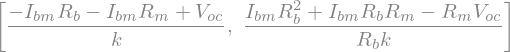

In [23]:
# what is omega crossover for duty cycle regime
sympy.solve(sympy.Eq(constant_power[0][Ic], duty_limit[0][Ic]), omega)

Maximum controller current at zero rpm.

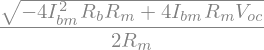

In [24]:
constant_power[0][Ic].subs(omega, 0)

The maximum controller current is possible when the maximum battery current is half the short circuit current

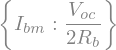

In [25]:
sympy.solve(constant_power[0][Ic].subs(omega, 0).diff(Ibm), 0, Ibm)

The maximum controller current is related to the open circuit voltage and the motor and battery resistance.
I think maybe this is the open circuit voltage divided by the geometric mean of the motor and battery resistances?

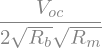

In [26]:
constant_power[0][Ic].subs(omega, 0).subs(Ibm, Voc / 2 / Rb)

# Unused Cruft Below

In [27]:
# Highest speed analytical solution

rho = sympy.Symbol('rho')
cd = sympy.Symbol('c_d')
area = sympy.Symbol('A')
radius = sympy.Symbol('r')

load_torque = sympy.Eq(torque, sympy.Rational(1,2) * rho * cd * area * radius**3 * omega**2)
high_rpm = sympy.Eq(torque/k, (Voc - k * omega) / (Rm +  Rb))

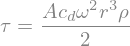

In [28]:
load_torque

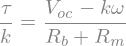

In [29]:
high_rpm

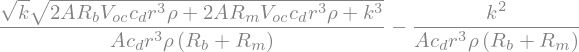

In [30]:
sympy.solve([load_torque, high_rpm], [torque, omega])[1][1]

In [31]:
sympy.solve([load_torque, high_rpm], [torque, omega])[1][1].subs(Rb, 0.141).subs(Rm, 0.06).subs(area, 0.504).subs(k, 1.2).subs(cd, 1).subs(radius, 0.32).subs(rho, 1.2).subs(Voc, 58)
                                                                                                                                      

In [32]:
Ibdiscriminant = sympy.Eq(Voc**2, 4 * Imm**2 * Rb * Rm - 4 * Imm * Rb * k * omega)

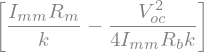

In [33]:
sympy.solve(Ibdiscriminant, omega)

In [34]:
Icdiscriminant = sympy.Eq(k**2 * omega**2, 4 * Ibm**2 * Rb * Rm - 4 * Ibm * Rm * Voc)

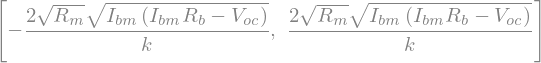

In [35]:
sympy.solve(Icdiscriminant, omega)

In [36]:
phase_limit[1][Ib]

NameError: name 'phase_limit' is not defined

In [ ]:
phase_limited_radical = phase_limit[1][Ib].args[2].args[1].args[0]
phase_limited_radical = phase_limit[0][Ib].args[2].args[1].args[1]
phase_limited_radical

In [ ]:
# omega where radical goes imaginary
omeganl = sympy.Symbol('omega_nl')
Isc = sympy.Symbol('I_sc')
phase_limited_radical

In [ ]:
sympy.solve(phase_limited_radical, 0, omega)[0][omega]
#.subs(Voc/k, omeganl).subs(Voc/Rb, Isc)

In [ ]:
sympy.diff(phase_limit[0][Ib], omega)

In [ ]:
sympy.together(sympy.solve(phase_limited_radical, 0, omega)[0][omega])

In [ ]:
battery_limit[0][Ic]

In [ ]:
sympy.diff(battery_limit[0][Ic], omega)

In [ ]:
(battery_limit[0][Ic] * battery_limit[0][Vc]).expand()

In [ ]:
phase_limit[0][Ib].subs(omega, 0).subs(Voc, Isc*Rb).expand()

In [ ]:
sympy.solve(Rb*Ib**2 - Ib * Voc + Imm**2 * Rm, 0, Ib)

In [ ]:
sympy.series(phase_limit[1][Ib], omega)